In [1]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.metrics import mean_squared_error

#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis
from matplotlib import style
style.use('seaborn-white')

np.random.seed(1000)  # Seed for reproducibility

In [2]:
data = "SIM_SEC,VEH_ID,POS_LONG,HDWY,ACC,VEL"
df = pd.read_csv('Book5.csv', header=None,low_memory=False, encoding='latin-1')
df = df.rename(columns={0:"SIM_SEC",1:"VEH_ID",2:"LINK",3:"LANE",4:"POS_LONG",5:"HDWY",6:"ACC",7:"SPEED",8:"POS_LAT"})
df = df.drop(['LINK','LANE','POS_LAT'], axis=1)
df = pd.DataFrame(df)

df.iat[0,0] = 0.5
df1 = df["VEH_ID"].value_counts().head(5)
print(df1)

50    10533
25    10533
27    10533
28    10533
29    10533
Name: VEH_ID, dtype: int64


In [3]:
x = np.zeros((100,10533,4)) #state measurements 
x_p = np.zeros((100,10533,4)) #state derivatives 

vehID = []
vehStart = []
traj_len = {}
traj_lens = []
for row in df.itertuples():
    if row[2] not in vehID:
        vehID.append(row[2])
        vehStart.append(row[1])
        traj_len[row[2]] = [0]
        time_step = 0
    else:   
        for t_step in range(10533):
            if x[row[2]-1][t_step][1]==0 and x[row[2]-1][t_step][2]==0 and x[row[2]-1][t_step][3]==0:
                traj_len[row[2]].append(t_step)
                time_step = t_step
                break 
    x[row[2]-1][time_step][0] = row[1] #SIM_SEC 
    x[row[2]-1][time_step][1] = row[6] #SPEED
    x[row[2]-1][time_step][2] = row[4] #HDWY=Headway 

    x_p[row[2]-1][time_step][0] = row[1] #SIM_SEC 
    x_p[row[2]-1][time_step][1] = row[5] #SPEED Derivative = ACC
   #x_p[row[2]-1][time_step][2] = row[4] #HDWY Derivative—calculated later using Finite Difference

    if row[0] == 0 or last_row[2] != row[2]-1:
        x[row[2]-1][time_step][2] = 4000 #HDWY reset if leading 
        x[row[2]-1][time_step][3] = 300 #speed reset if leading 
        x_p[row[2]-1][time_step][3] = 0 #not accelerating if leading
        #x_p[row[2]-1][time_step][2] = 0 #HDWY derivative—calculate later using Finite Difference
    else:
        x[row[2]-1][time_step][3] = last_row[6] #leading vehicle speed
        x_p[row[2]-1][time_step][3] = last_row[5] #leading vehicle acceleration 
    last_row = row
    if row[0] == 1048479:
       #print(vehID) 
       #print(vehStart)
        for g in range(len(vehID)):
            traj_lens.append(len(traj_len[g+1]))
       #print(traj_lens)    
        break  

In [205]:
# Convert data from np arrays to lists for each vehicle 

t = [] #time 
v = [] #velocity 
s = [] #Headway
vlead = [] #leading velocity 
v_p = [] #ACC = v prime 
vlead_p = [] #leading ACC 

for k in range(10532): #10533 changed it to 10532 to avoid the last zero
    vehNo = 80
    if x[vehNo][k][2]==4000 and x[vehNo][k][3]==300: #truncating the traj by eliminating zeros (each vehicle has 771 time_step traj by now) 
        print(k)
        break 
    t.append(x[vehNo][k][0])  
    v.append(x[vehNo][k][1])
    s.append(x[vehNo][k][2])
    vlead.append(x[vehNo][k][3]) 
    v_p.append(x_p[vehNo][k][1])
    vlead_p.append(x_p[vehNo][k][3])

In [206]:
# Convert lists to numpy arrays

t = np.asarray(t)
v = np.asarray(v)
s = np.asarray(s)
vlead = np.asarray(vlead)
v_p = np.asarray(v_p)
vlead_p = np.asarray(vlead_p)

print(v)
v = (v - np.mean(v)) / np.var(v)
s = (s - np.mean(s)) / np.var(s)
vlead = (vlead - np.mean(vlead)) / np.var(vlead)

#v = (v - v.min()) / (v.max() - v.min())
#s = (s - s.min()) / (s.max() - s.min())
#vlead = (vlead - vlead.min()) / (vlead.max() - vlead.min())

[23.7571302 23.7747713 23.7924123 ... 21.9632458 21.9367841 21.9104275]


In [179]:


# Calculating the Headway Derivative 

FD = ps.SmoothedFiniteDifference()
s_p = FD(s, t) #HDWY Derivative #(670,1)
s_p = np.reshape(s_p, (v_p.size,)) #(670,)
v_p_new = FD(v, t) #HDWY Derivative #(670,1)
v_p_new = np.reshape(v_p_new, (v_p.size,)) #(670,)
vlead_p_new = FD(vlead, t) #HDWY Derivative #(670,1)
vlead_p_new = np.reshape(vlead_p_new, (v_p.size,)) #(670,)

#print(vlead_p_new[:40])
#print(len(v))
#print(s_p[:40])

[-0.00264107 -0.0026026  -0.00256432 ... -0.00456554 -0.00459963
 -0.0109662 ]


(10532, 3)
v' = 0.695 sin(1 v) + -0.415 cos(1 v) + 0.330 sin(1 s) + 0.158 cos(1 v_l)
s' = 0.925 sin(1 v) + -0.352 cos(1 v) + -1.005 sin(1 v_l) + 0.389 cos(1 v_l)
v_l' = 1.071 sin(1 v) + -0.268 cos(1 v) + 0.272 sin(1 s) + -0.144 cos(1 v_l)


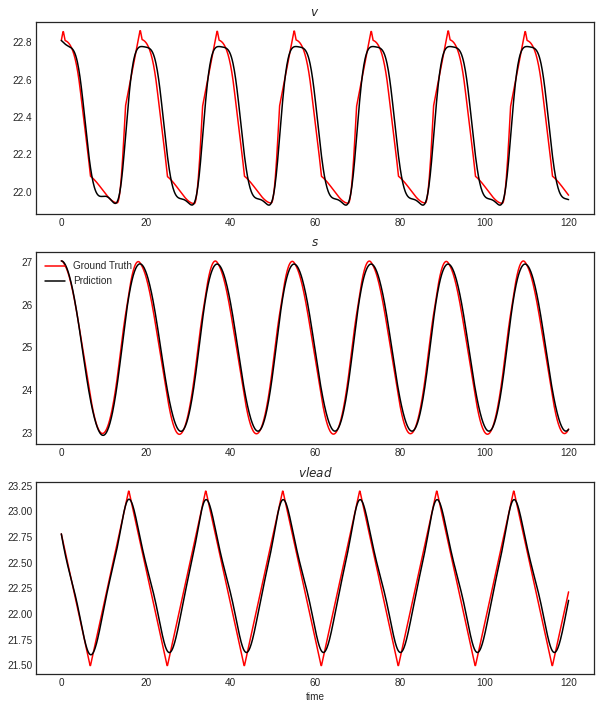

In [105]:
# Fit the model 
dt = 0.1
poly_order = 3
threshold = 0.1
trunc_traj = 0
end_traj = -1
x_train = np.stack((v[trunc_traj:end_traj],s[trunc_traj:end_traj],vlead[trunc_traj:end_traj]), axis=-1)
#print(len(x_train))

feature_library1 = ps.FourierLibrary() 
feature_library2 = ps.PolynomialLibrary(degree=poly_order)
feature_library3 = ps.FourierLibrary() + ps.PolynomialLibrary(degree=poly_order)
x_p_train = np.stack((v_p[trunc_traj:end_traj],s_p[trunc_traj:end_traj],vlead_p[trunc_traj:end_traj]), axis=-1)
x_p_train_new = np.stack((v_p_new[trunc_traj:end_traj],s_p[trunc_traj:end_traj],vlead_p_new[trunc_traj:end_traj]), axis=-1)
#print(len(x_p_train_new))
#print(x_train[0])
#print(x_train[:2000, 1]==s[1000:3000])
print(x_train.shape)
#print(len(v[:35000]))

#*******************#

feature_names = ['v', 's', 'v_l']
model = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold),
        feature_library=feature_library1,
        feature_names=feature_names         
        )

model.fit(x_train,t=dt,x_dot=x_p_train_new)
model.print()

# Simulate the model 

t_sim = np.arange(0,120, dt)
sim_start = 3445

x_sim = model.simulate(x_train[sim_start], t_sim)

#print(x_train[1000])

#*******************#

fig, (ax1,ax2,ax3) = plt.subplots(3)
startTraj = sim_start
endTraj = startTraj + 1200

fig.set_figheight(12)
fig.set_figwidth(10)

ax1.plot(t_sim, x_train[startTraj:endTraj, 0], "r")
ax1.plot(t_sim, x_sim[:, 0], "k")
ax1.set_title('$v$')

g1, = ax2.plot(t_sim, x_train[startTraj:endTraj, 1], "r")
p1, = ax2.plot(t_sim, x_sim[:, 1], "k")
ax2.set_title('$s$')
ax2.legend((g1, p1), ('Ground Truth', 'Prdiction'), loc='upper left', shadow=False)

ax3.plot(t_sim, x_train[startTraj:endTraj, 2], "r")
ax3.plot(t_sim, x_sim[:, 2], "k")
ax3.set_title('$vlead$')
plt.xlabel("time")

#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

In [106]:
# mean squared error 
mse = mean_squared_error(x_train[startTraj:endTraj, :], x_sim[:, :])
print(mse)

0.008573163486108345


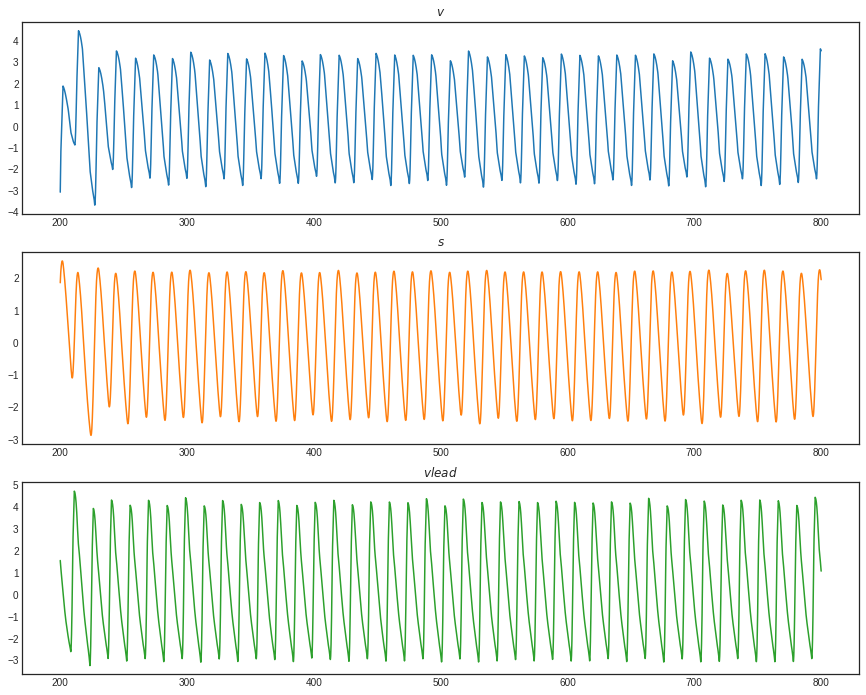

In [165]:
# Plotting the data  

fig, (ax1,ax2,ax3) = plt.subplots(3)
statTraj = 0
endsTraj = 6000
fig.set_figheight(12)
fig.set_figwidth(15)
ax1.plot(t[statTraj:endsTraj], v[statTraj:endsTraj])
ax1.set_title('$v$')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.set_title('$vlead$')

plt.show() 

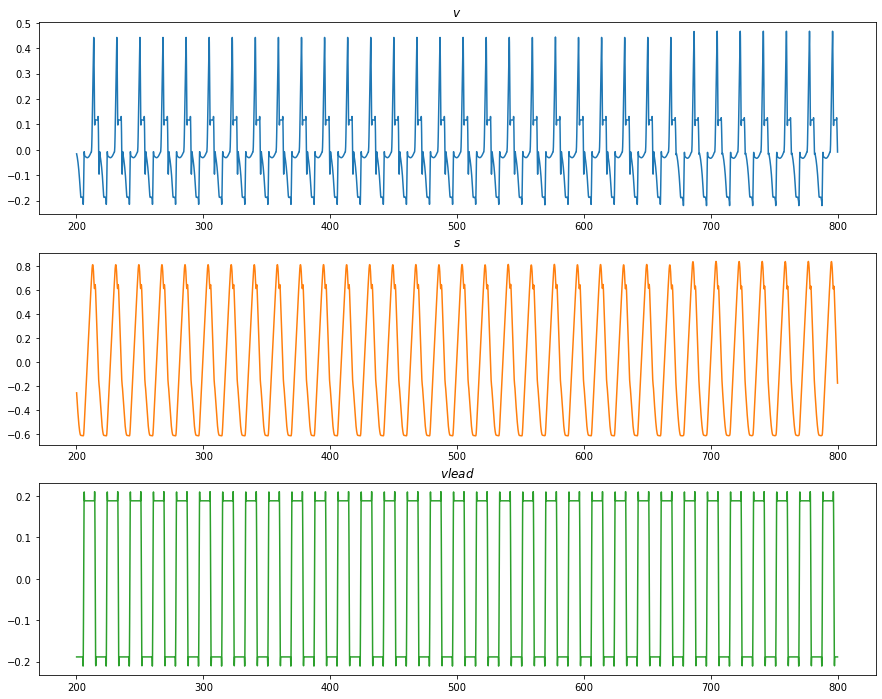

In [100]:
# Plotting the derivatives 

fig, (ax1,ax2,ax3) = plt.subplots(3)
statTraj = 0
endsTraj = 6000
fig.set_figheight(12)
fig.set_figwidth(15)
ax1.plot(t[statTraj:endsTraj], v_p_new[statTraj:endsTraj])
ax1.set_title('$v$')
ax2.plot(t[statTraj:endsTraj], s_p[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead_p_new[statTraj:endsTraj], 'tab:green')
ax3.set_title('$vlead$')

plt.show()

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


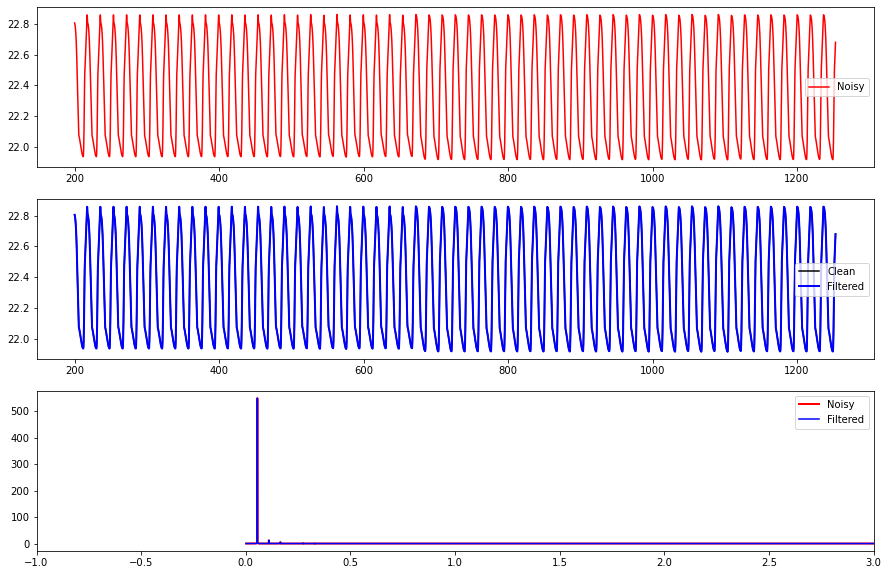

In [101]:
# FFT for CprE 575
sigLen = 0
maxLen = -1
n = len(t[sigLen:maxLen])
fhat = np.fft.fft(v[sigLen:maxLen],n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
freq = (1/(dt*n)) * np.arange(n)          # Create x-axis of frequencies in Hz
L = np.arange(1,np.floor(n/2),dtype='int')   # Only plot the first half of freqs

## Use the PSD to filter out noise
indices = PSD > 0.0000001     # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
#print(PSD[:20])
ffilt_v = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

fig,axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(15)

plt.sca(axs[0])
plt.plot(t[sigLen:maxLen],v[sigLen:maxLen],color='r',linewidth=1.5,label='Noisy')
#plt.xlim(t[sigLen],t[maxLen])
plt.legend()

plt.sca(axs[1])
plt.plot(t[sigLen:maxLen],v[sigLen:maxLen],color='k',linewidth=1.5,label='Clean')
plt.plot(t[sigLen:maxLen],ffilt_v,color='b',linewidth=2,label='Filtered')
#plt.xlim(t[sigLen],t[maxLen])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L],color='r',linewidth=2,label='Noisy')
plt.plot(freq[L],PSDclean[L],color='b',linewidth=1.5,label='Filtered')
plt.xlim(-1,3)
plt.legend()

#plt.savefig('ResearchUpdate#39/badFFT3.png')
plt.show()

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


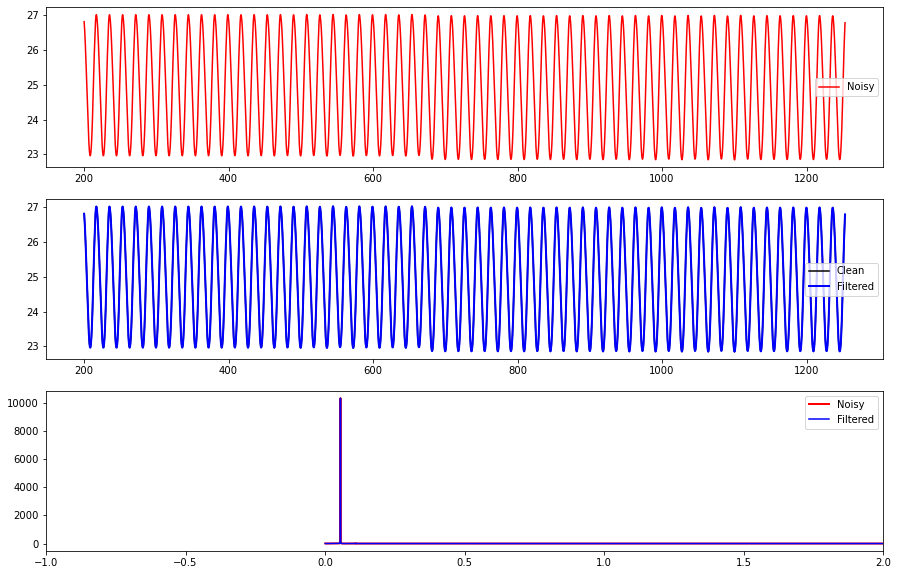

In [105]:
# FFT Denoising Distance Headway 
sigLen = 0
maxLen = -1
n = len(t[sigLen:maxLen])
fhat = np.fft.fft(s[sigLen:maxLen],n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
freq = (1/(dt*n)) * np.arange(n)          # Create x-axis of frequencies in Hz
#freq = np.fft.fftfreq(len(s[sigLen:maxLen]), dt)
#print(freq[40:100])
L = np.arange(1,np.floor(n/2),dtype='int')   # Only plot the first half of freqs
#print(len(PSD[L])) 

## Use the PSD to filter out noise
indices = PSD > 0.0000001      # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
#print(PSD[:20])
ffilt_s = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

fig,axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(15)

plt.sca(axs[0])
plt.plot(t[sigLen:maxLen],s[sigLen:maxLen],color='r',linewidth=1.5,label='Noisy')
#plt.xlim(t[sigLen],t[maxLen])
plt.legend()

plt.sca(axs[1])
plt.plot(t[sigLen:maxLen],s[sigLen:maxLen],color='k',linewidth=1.5,label='Clean')
plt.plot(t[sigLen:maxLen],ffilt_s,color='b',linewidth=2,label='Filtered')
#plt.xlim(t[sigLen],t[maxLen])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L],color='r',linewidth=2,label='Noisy')
plt.plot(freq[L],PSDclean[L],color='b',linewidth=1.5,label='Filtered')
plt.xlim(-1,2)
plt.legend()

plt.show()

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


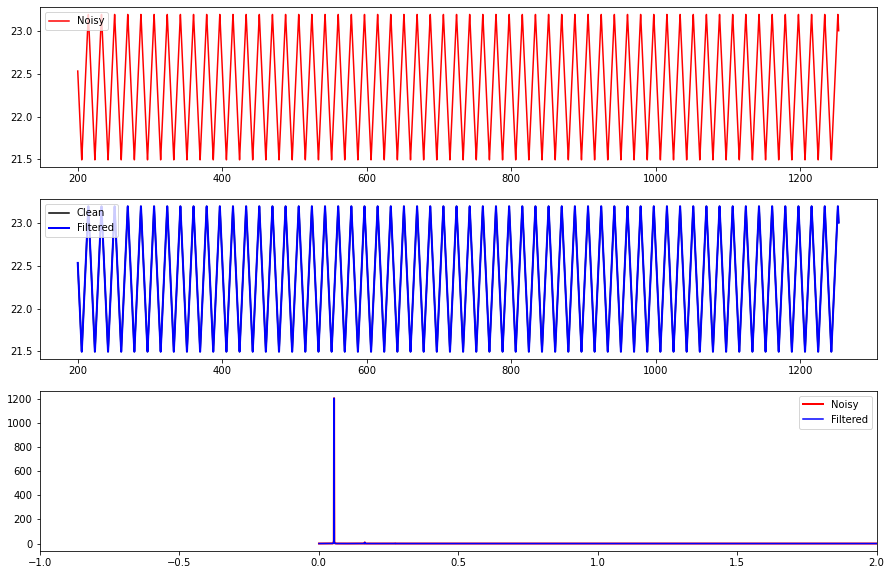

In [106]:
# FFT Denoising leading Velocity
sigLen = 0
maxLen = -1
n = len(t[sigLen:maxLen])
fhat = np.fft.fft(vlead[sigLen:maxLen],n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
freq = (1/(dt*n)) * np.arange(n)          # Create x-axis of frequencies in Hz
#print(freq[-1])
L = np.arange(1,np.floor(n/2),dtype='int')   # Only plot the first half of freqs
#print(PSD[L]) 

## Use the PSD to filter out noise
indices = PSD > 0.0000001     # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
#print(PSD[:20])
ffilt_vlead = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

fig,axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(15)

plt.sca(axs[0])
plt.plot(t[sigLen:maxLen],vlead[sigLen:maxLen],color='r',linewidth=1.5,label='Noisy')
#plt.xlim(t[sigLen],t[maxLen])
plt.legend()

plt.sca(axs[1])
plt.plot(t[sigLen:maxLen],vlead[sigLen:maxLen],color='k',linewidth=1.5,label='Clean')
plt.plot(t[sigLen:maxLen],ffilt_vlead,color='b',linewidth=2,label='Filtered')
#plt.xlim(t[sigLen],t[maxLen])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L],color='r',linewidth=2,label='Noisy')
plt.plot(freq[L],PSDclean[L],color='b',linewidth=1.5,label='Filtered')
plt.xlim(-1,2)
plt.legend()

plt.show()
